In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mvica_lingam.mvica_lingam import mvica_lingam

# sample data

In [2]:
# parameters
m = 5
p = 4
n = 1000
nb_gaussian_sources = 2  # should be between 0 and p
random_state = 42
rng = np.random.RandomState(random_state)

In [3]:
# function that samples data according to our model
# we use similar parameters as in Fig. 2 of the ShICA paper
def sample_data(m, p, n, nb_gaussian_sources=0, rng=None):
    # sources
    S_ng = rng.laplace(size=(p-nb_gaussian_sources, n))
    S_g = rng.normal(size=(nb_gaussian_sources, n))
    S = np.vstack((S_ng, S_g))

    # noise
    sigmas = np.ones((m, p)) * 1 / 2
    if nb_gaussian_sources != 0:
        sigmas[:, -nb_gaussian_sources:] = rng.uniform(size=(m, nb_gaussian_sources))
    N = rng.normal(scale=sigmas[:, :, np.newaxis], size=(m, p, n))

    # causal effect matrices
    B = rng.normal(size=(m, p, p))
    for i in range(m):
        B[i][np.triu_indices(p, k=0)] = 0  # set the strictly upper triangular part to 0
    
    # causal order
    P = np.eye(p)
    rng.shuffle(P)

    # mixing matrices
    A = P.T @ np.linalg.inv(np.eye(p) - B) @ P

    # observations
    X = np.array([Ai @ Si for Ai, Si in zip(A, S + N)])
    
    return X, P, B

In [4]:
# generate observations X, causal order P, and causal effects B
X, P, B = sample_data(m, p, n, nb_gaussian_sources, rng)

# Multiview LiNGAM

In [5]:
# apply our main function to retrieve P and B; it takes time because of ShICA-ML
P_estimate, B_estimates, Sigmas_estimates, S_avg_estimate, _ = mvica_lingam(
    X, ica_algo="shica_ml", random_state=random_state)

# compare true and estimated causal orders P

In [6]:
# check that causal order P is well-retrieved
if (P_estimate == P).all():
    print("The causal order P is retrieved!")
else:
    print("The causal order P is not retrieved.")

The causal order P is retrieved!


# compare true and estimated causal effects B

In [7]:
# plot heat maps of causal effect matrices
def heat_maps_B(B, title_add=""):
    m = len(B)
    fontsize = 18
    fig, axes = plt.subplots(1, m, figsize=(m*5, 5))
    norm = TwoSlopeNorm(vmin=np.min(B), vmax=np.max(B), vcenter=0)
    for i, ax in enumerate(axes.flat):
        im = ax.imshow(B[i], norm=norm, cmap="coolwarm")
        ax.set_title(f"View {i}", fontsize=fontsize)
    cbar = fig.colorbar(im, ax=axes, fraction=0.0085, pad=0.015)
    cbar.set_label('Color Scale', fontsize=fontsize)
    fig.suptitle(f"{title_add} causal effect matrices", fontsize=fontsize)
    fig.supxlabel("components", fontsize=fontsize)
    fig.supylabel("components", fontsize=fontsize, x=0.1)
    plt.show()

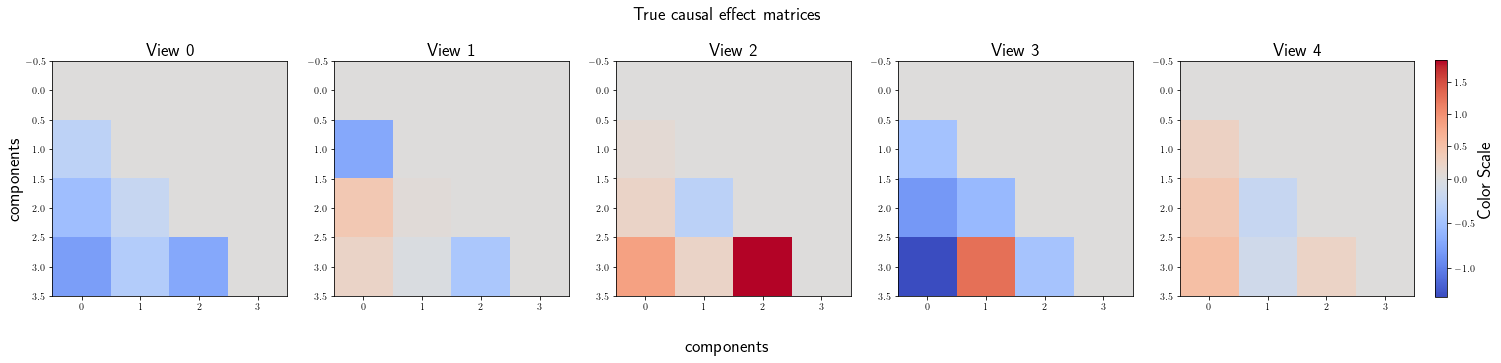

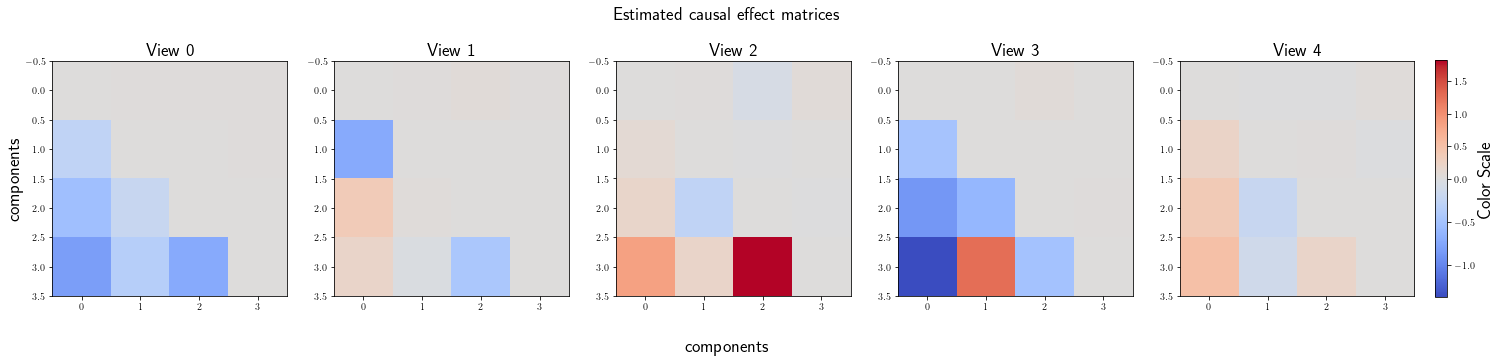

In [8]:
heat_maps_B(B, title_add="True")
heat_maps_B(B_estimates, title_add="Estimated")

In [9]:
error = np.mean((B_estimates - B) ** 2)
print(f"The average error is {error:.4f}.")

The average error is 0.0004.
